# EX.10

![ex_10.PNG](./ex_10.PNG)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm

In [2]:
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

In [5]:
carseats = load_data('Carseats')
carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [6]:
X = MS(['Price', 'Urban', 'US']).fit_transform(carseats)
X

,intercept,Price,Urban[Yes],US[Yes]
0,1.0,120,1.0,1.0
1,1.0,83,1.0,1.0
2,1.0,80,1.0,1.0
3,1.0,97,1.0,1.0
4,1.0,128,1.0,0.0
...,...,...,...,...
395,1.0,128,1.0,1.0
396,1.0,120,0.0,1.0
397,1.0,159,1.0,1.0
398,1.0,95,1.0,1.0


In [7]:
y = carseats['Sales']

In [17]:
# Build the formula for regression
formula = 'Sales ~  + Price + Urban + US'
# Fit the model using formula API
model1 = ols(formula, data=carseats).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           2.39e-23
Time:                        11:27:33   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0435      0.651     20.036      0.000      11.764      14.323
Urban[T.Yes]    -0.0219      0.272     -0.081      0.936      -0.556       0.512
US[T.Yes]        1.2006      0.259      4.635      0.000       0.691       1.710
Price           -0.0545      0.005    -10.389      0.000      -0.065      -0.044
==============================================================================
Omnibus:                        0.676   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.758
Skew:                           0.093   Prob(JB):                        0.684
Kurtosis:                       2.897   Cond. No.                         628.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<li> Price results to be inversely proportional to sales: keeping Urban and US constant, if we increase the price of 1 unit, the sales will decrease of roughly 0.05 (in thousands) of unit sales. 
<li> Ceteris paribus, if a store is in the US the Sales will increase by 1.2 (thousands) of unit sales.
<li> Ceteris paribus, if a store is in an urban location it makes slightly less sales than a rural one with a difference of 0.02 (in thousands) of unit sales.

The pvalue of the Urban variable is above the 0.05 threshold, so we cannot reject the Null hypothesis and suppose there is a connection between the predictor and the response.

In [9]:
#Using sklearn
#X_sk = carseats[['Price', 'Urban', 'US']]
X = X[X.columns.drop('intercept')]
model_sk = make_pipeline(PolynomialFeatures(1), LinearRegression())
model_sk.fit(X, y)
# Access the linear model
linreg = model_sk.named_steps['linearregression']

# Get coefficients and intercept
print("Intercept:", linreg.intercept_)
print("Coefficients:", linreg.coef_)

Intercept: 13.0434689367649
Coefficients: [ 0.         -0.05445885 -0.02191615  1.2005727 ]


Equation form of the regression:
\begin{equation}
    \textbf{Sales} = \beta_0 + \beta_1 * \mathbf{price} + 
    \begin{cases} 
    \beta_2 \ \text{if in} \ \textbf{Urban} \\
    0 \  \ \text{otherwise}
    \end{cases} +
    \begin{cases} 
    \beta_3 \ \text{if in the} \ \textbf{US} \\
    0 \  \ \text{otherwise}
    \end{cases}
\end{equation}
since both **Urban** and **US** are qualitative, one-hot encoded variables. Where $\beta_0 = 13.04$, $\beta_1 = -0.0545$, $\beta_2 = -0.0219$ and $\beta_3 = 1.2006$.

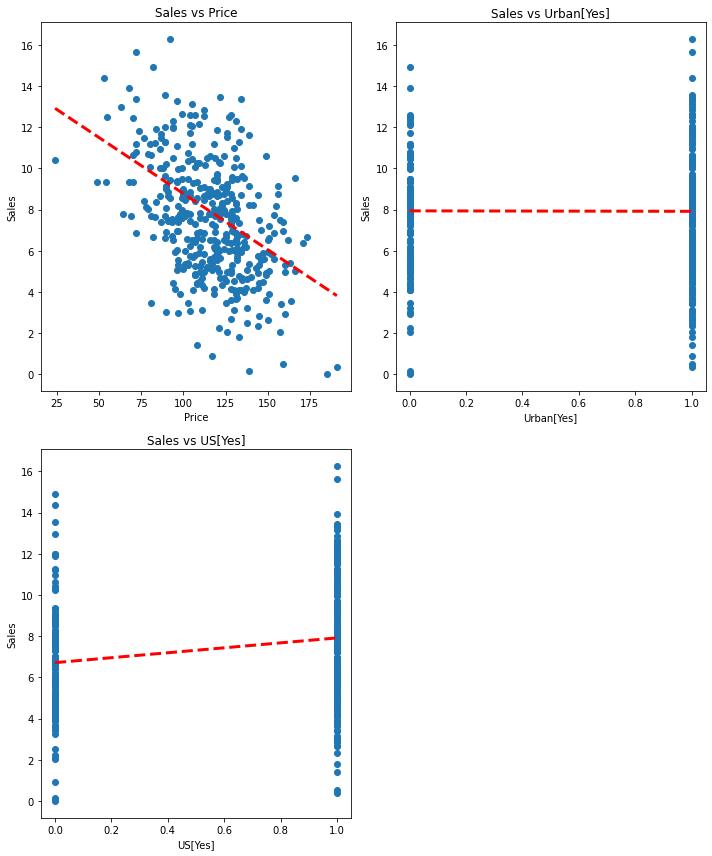

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 12))
axes = axes.flatten()  # Flatten for easy indexing
colors = plt.colormaps.get_cmap('tab10').resampled(len(X))
#

for i, col in enumerate(X):
    ax = axes[i]
    feature_range = np.linspace(X[col].min(), X[col].max(), 400).reshape(-1, 1)
    fixed_params = X.columns.drop([col])
    x_vals_lin = pd.DataFrame({'Price': [X['Price'].mean()] * 400,
                                'Urban[Yes]': np.ones([len(X)]),  
                                'US[Yes]': np.ones([len(X)])})
    x_vals_lin[col] = feature_range
    
    ax.scatter(X[col], carseats['Sales'], color = colors(i), label=col)
    ax.set_title(f'Sales vs {col}')
    ax.set_ylabel('Sales')
    ax.set_xlabel(col)
    # Predict using the same transformation
    y_pred_lin = model_sk.predict(x_vals_lin)
    ax.plot(feature_range, y_pred_lin, 'r--', linewidth = 3)
    

# Hide any unused subplots (if you have more axes than plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

Due to the previous considerations we build a second model, excluding the Urban predictor.

In [13]:
X2 = MS(['Price', 'US']).fit_transform(carseats)
X2

,intercept,Price,US[Yes]
0,1.0,120,1.0
1,1.0,83,1.0
2,1.0,80,1.0
3,1.0,97,1.0
4,1.0,128,0.0
...,...,...,...
395,1.0,128,1.0
396,1.0,120,1.0
397,1.0,159,1.0
398,1.0,95,1.0


In [18]:
# Build the formula for regression
formula_red = 'Sales ~  + Price + US'
# Fit the model using formula API
model2 = ols(formula_red, data=carseats).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           2.66e-24
Time:                        11:28:10   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0308      0.631     20.652      0.000      11.790      14.271
US[T.Yes]      1.1996      0.258      4.641      0.000       0.692       1.708
Price         -0.0545      0.005    -10.416      0.000      -0.065      -0.044
==============================================================================
Omnibus:                        0.666   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.749
Skew:                           0.092   Prob(JB):                        0.688
Kurtosis:                       2.895   Cond. No.                         607.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
print("AIC difference:", model2.aic - model1.aic)
print("BIC difference:", model2.bic - model1.bic)

AIC difference: -1.9934253976366563
BIC difference: -5.984889944744509


The new model is simpler without changing much the performances (slight improvement).

In [22]:
# Computes the confidence intervals
print(model2.conf_int(alpha=0.05))

                  0          1
Intercept  11.79032  14.271265
US[T.Yes]   0.69152   1.707766
Price      -0.06476  -0.044195


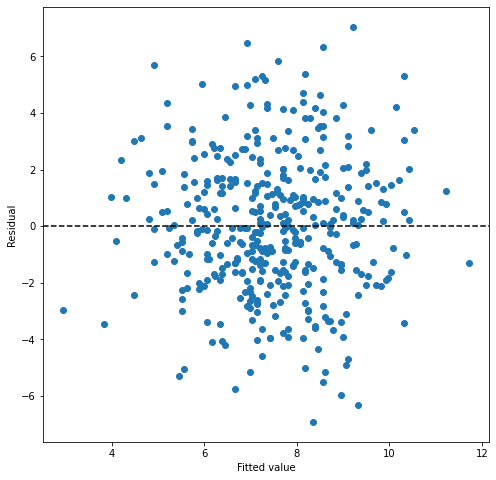

In [23]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(model2.fittedvalues , model2.resid)
#ax.scatter(result_all.fittedvalues.iloc[highlight_idx] , result_all.resid.iloc[highlight_idx], color='cyan', s=100, label=f'Index {highlight_idx}')
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

42

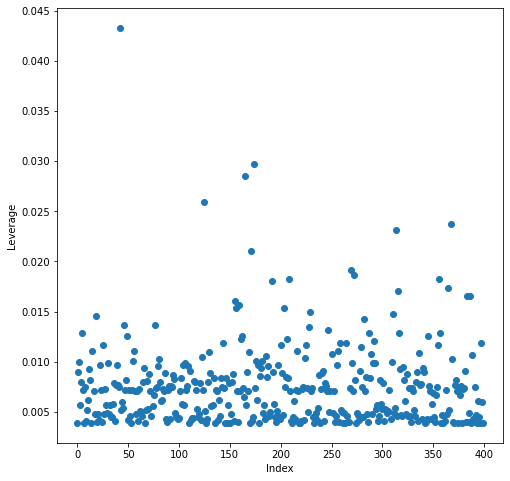

In [24]:
infl_all = model2.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
#Leverage statistics can be computed for any number of predictors using the hat_matrix_diag attribute of the value returned by the get_influence() method.
ax.scatter(np.arange(X2.shape[0]), infl_all.hat_matrix_diag)
#ax.scatter(np.arange(X2.shape[0])[highlight_idx] , infl_all.hat_matrix_diag[highlight_idx], color='cyan', s=100, label=f'Index {highlight_idx}')
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
# maximized over the entire array to determine which observation has the largest leverage statistic.
np.argmax(infl_all.hat_matrix_diag)

In [25]:
n = X2.shape[0]
p = X2.shape[1] - 1  # subtract intercept
leverage = infl_all.hat_matrix_diag

leverage_threshold = 2 * (p + 1) / n
high_leverage_points = np.where(leverage > leverage_threshold)[0]

print("High leverage points (index positions):", high_leverage_points)
print("Leverage values of these points:", leverage[high_leverage_points])

High leverage points (index positions): [ 42 125 155 156 159 165 171 174 191 203 208 269 272 313 315 356 365 367
 383 386]
Leverage values of these points: [0.04333766 0.02596614 0.01610616 0.01535558 0.01570737 0.02856661
 0.02101401 0.02968672 0.0180391  0.01535558 0.01823472 0.01919494
 0.01868734 0.0231647  0.01704881 0.01827894 0.01739884 0.02370705
 0.01651393 0.01655462]


In [26]:
#Raw residuals aren't always directly comparable across data points because they may have different variances. So instead, we use:
# Standardized residuals: residuals divided by their estimated standard deviation.
# Studentized residuals: similar but better for detecting outliers, especially when leverage varies.

studentized_residuals = infl_all.resid_studentized_external
high_resid_points = np.where(np.abs(studentized_residuals) > 2)[0]

print("High residual points (indices):", high_resid_points)
print("Studentized residuals of these points:", studentized_residuals[high_resid_points])

High residual points (indices): [ 17  25  28  30  49  50  57  62  68  82  98 106 143 209 258 297 298 304
 316 328 352 376 395]
Studentized residuals of these points: [ 2.11850399  2.59965175 -2.43374524  2.19494228  2.33437613 -2.83584311
 -2.34878813 -2.10592255  2.64236365  2.02335944  2.11065036 -2.1662848
 -2.06096069 -2.58158616 -2.10634988 -2.24156887  2.05414267  2.03794216
  2.17940209 -2.05066437  2.3901782   2.89152132  2.16621032]


In [27]:
high_lev_and_res = np.intersect1d(high_leverage_points, high_resid_points)
print("High leverage and residual points (indices):", high_lev_and_res)

High leverage and residual points (indices): []


There are no points with both an high leverage and an high residue.

![lev_res.PNG](./lev_res.PNG)